In [1]:
import numpy as np
from scipy.sparse.linalg import expm_multiply, expm
from scipy.sparse import lil_matrix, kron
import matplotlib.pyplot as plt
from qiskit.synthesis import SuzukiTrotter
from scipy.optimize import minimize, linprog
from scipy.linalg import eigh, eig
import random
import cmath

In [3]:
# pauli matrices
pauli = np.array([np.array([[1,0],[0,1]]), np.array([[0,1],[1,0]]), np.array([[0,-1.j],[1.j,0]]), np.array([[1,0],[0,-1]])])
pauli_tensor = np.array([[np.kron(pauli[i], pauli[j]) for i in range(4)] for j in range(4)])

# building operators 
def kronecker_pad(matrix, num_qubits, starting_site): 
    ''' pads a 1- or 2- local operator with identities on other sites to get 2^n by 2^n matrix '''
    kron_list = [np.eye(2) for i in range(num_qubits)]    
    kron_list[starting_site] = matrix
    if matrix.shape[0] == 4: 
        del kron_list[starting_site+1]
    
    padded_matrix = kron_list[0]
    for i in range(1, len(kron_list)):
        padded_matrix = np.kron(kron_list[i], padded_matrix)    
    return padded_matrix

# models
def heisenberg(num_qubits, bias_coeff=1.0, x_hopping_coeff=1.0, y_hopping_coeff=1.0, z_hopping_coeff=1.0): 
    terms = []
    # for i in range(num_qubits): 
    #     bias = bias_coeff*kronecker_pad(pauli[3], num_qubits, i)
    #     terms.append(bias)
        
    for i in range(num_qubits-1): 
        z_hop = z_hopping_coeff*kronecker_pad(pauli_tensor[(3,3)], num_qubits, i)
        terms.append(z_hop)
        y_hop = y_hopping_coeff*kronecker_pad(pauli_tensor[(2,2)], num_qubits, i)
        terms.append(y_hop)
        x_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(1,1)], num_qubits, i)
        terms.append(x_hop)
    
    return sum(terms)

def trotter(num_qubits, bias_coeff=1.0, x_hopping_coeff=1.0, y_hopping_coeff=1.0, z_hopping_coeff=1.0):
    even_terms = []
    odd_terms = []

    for i in range(0, num_qubits-1, 2):
        z_hop = z_hopping_coeff*kronecker_pad(pauli_tensor[(3,3)], num_qubits, i)
        odd_terms.append(z_hop)
        y_hop = y_hopping_coeff*kronecker_pad(pauli_tensor[(2,2)], num_qubits, i)
        odd_terms.append(y_hop)
        x_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(1,1)], num_qubits, i)
        odd_terms.append(x_hop)
    for i in range(1, num_qubits-1, 2):
        z_hop = z_hopping_coeff*kronecker_pad(pauli_tensor[(3,3)], num_qubits, i)
        even_terms.append(z_hop)
        y_hop = y_hopping_coeff*kronecker_pad(pauli_tensor[(2,2)], num_qubits, i)
        even_terms.append(y_hop)
        x_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(1,1)], num_qubits, i)
        even_terms.append(x_hop)

    even = sum(even_terms)
    odd = sum(odd_terms)

    return even, odd



def xy(num_qubits, x_hopping_coeff=1.0, y_hopping_coeff=1.0):
    terms = []

    for i in range(num_qubits-1):
        x_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(1,1)], num_qubits, i)
        terms.append(x_hop)
        y_hop = x_hopping_coeff*kronecker_pad(pauli_tensor[(2,2)], num_qubits, i)
        terms.append(y_hop)

    return sum(terms)

n = 8
H = heisenberg(n, x_hopping_coeff=1, y_hopping_coeff=2, z_hopping_coeff=3)
# H = xy(n)
H.real

array([[21.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 15.,  3., ...,  0.,  0.,  0.],
       [ 0.,  3.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  9.,  3.,  0.],
       [ 0.,  0.,  0., ...,  3., 15.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 21.]])

In [6]:
tau = 0.1
even, odd = trotter(n)
expm_est_trot = expm(-1j * tau * even) @ expm(-1j * tau * odd)

tf = 10
ts = [0]
while ts[-1] < tf:
    ts.append(ts[-1] + tau)

c = list("010101") 
UnitVector = lambda c: np.eye(2**n)[c]
init = UnitVector(int(''.join(c), 2))

exact_te = [expm_multiply(-1j * t * H, init) for t in ts]
trot_te = [np.linalg.matrix_power(expm_est_trot, i) @ init for i, _ in enumerate(ts)]
exact_trot_te = [np.linalg.matrix_power(expm(-1j * tau * H), i) @ init for i, _ in enumerate(ts)]

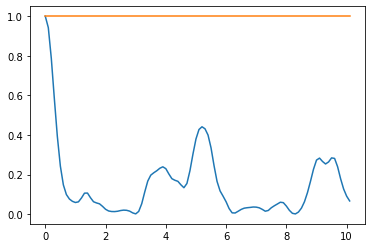

In [8]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

# O = np.kron(np.kron(I, Z), np.kron(Z, I))
# O = np.kron(np.kron(Z, I), I)

# Z_exact = [np.conj(psi) @ O @ psi for psi in exact_te]
# Z_trot = [np.conj(psi) @ O @ psi for psi in trot_te]
exact_auto = [np.abs(np.conj(init) @ psi)**2 for psi in exact_te]
trot_auto = [np.abs(np.conj(init) @ psi)**2 for psi in trot_te]
fidelity = [np.abs(np.conj(psi) @ phi)**2 for psi, phi in zip(exact_te, trot_te)]
trot_exact_fidelity = [np.abs(np.conj(psi) @ phi)**2 for psi, phi in zip(exact_te, exact_trot_te)]

# plt.plot(ts, exact_auto)
# plt.plot(ts, trot_auto)
plt.plot(ts, fidelity)
plt.plot(ts, trot_exact_fidelity)

In [4]:
# def compute_Hkl(ref_states, Ham):
#     dim = len(ref_states)
#     Hkl = np.zeros((dim, dim), dtype=np.complex64)

#     for i in range(dim):
#         for j in range(dim):
#             Hkl[i][j] = (np.conj(ref_states[i]) @ Ham @ ref_states[j])
#     return Hkl

# def compute_S(ref_states):
#     dim = len(ref_states)
#     S = np.zeros((dim, dim), dtype=np.complex64)

#     for i in range(dim):
#         for j in range(dim):
#             S[i][j] = (np.conj(ref_states[i]) @ ref_states[j])
#     return S

def compute_Hkl(Ham, basis_set): 
    eff_H = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(len(basis_set)): 
            eff_H[i][j] = basis_set[i].conj().T @ Ham @ basis_set[j]
    return eff_H    

def compute_S(basis_set): 
    eff_S = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(len(basis_set)): 
            eff_S[i][j] = basis_set[i].conj().T @ basis_set[j]
    return eff_S

def random_initial_state(n):
    components = [complex(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(n)]
    magnitude = cmath.sqrt(sum(comp.real**2 + comp.imag**2 for comp in components))
    normalized_vector = [comp / magnitude for comp in components]
    
    return np.array(normalized_vector)

In [4]:
tf = 10
ts = np.linspace(0, tf, 200)

# init = random_initial_state(2**n)

c = list("010101") 
UnitVector = lambda c: np.eye(2**n)[c]
init = UnitVector(int(''.join(c), 2))

ref_states = [init]
added_indices = []
M = 8
num_ref_states = 1
tau = 0.1

expm_est = expm(-1j * tau * H) # should be trotterized really, eventually

for j in range(num_ref_states):
    for i in range(1, M):
        new_states = []
        new_states.append(expm_multiply(-1j * i * tau * H, ref_states[-1]))
        ref_states.extend(new_states)
    if (j < num_ref_states - 1):
        # should take second most probable if the first one is already in there
        xs = np.eye(2**n)
        # probs = [ np.abs(np.conj(x) @ ref_states[-1])**2 for x in xs]
        # ref_states.append(xs[np.argmax(probs)])

        sorted_probs_inds = np.argsort([np.abs(np.conj(x) @ ref_states[-1])**2 for x in xs])[::-1]
        for k in range(len(sorted_probs_inds)):
            if not (sorted_probs_inds[k] in added_indices):
                ref_states.append(xs[sorted_probs_inds[k]])
                added_indices.append(sorted_probs_inds[k])
                break

In [6]:
Hkl = compute_Hkl(H, ref_states)
S = compute_S(ref_states)
print(S)

U, D, Vh = np.linalg.svd(S)
print(D)
eps = 1e-5
D[np.abs(D) < eps] = 0
D_inv = [1/d if d > 0 else 0 for d in D]
S_inv = Vh.conj().T @ np.diag(D_inv) @ U.conj().T

# c0 = np.linalg.inv(S) @ S[:,0]
c0 = np.zeros(len(ref_states))
c0[0] = 1
# c0

[[ 1.        +0.j          0.93603023-0.2909271j   0.49390544-0.6743622j
  -0.29117147-0.4303668j  -0.14267358+0.37078593j  0.40280067-0.23580936j
  -0.3799935 -0.46238192j -0.28866316+0.01199232j]
 [ 0.93603023+0.2909271j   1.        +0.j          0.75614044-0.5296208j
  -0.07989235-0.61333252j -0.30997624+0.24931705j  0.4271892 -0.02995303j
  -0.2939353 -0.54591219j -0.32226298-0.04172057j]
 [ 0.49390544+0.6743622j   0.75614044+0.5296208j   1.        +0.j
   0.49390544-0.6743622j  -0.40399519-0.19332576j  0.23752928+0.32009257j
  -0.00668984-0.6011838j  -0.3833681 -0.14332023j]
 [-0.29117147+0.4303668j  -0.07989235+0.61333252j  0.49390544+0.6743622j
   1.        +0.j          0.1975472 -0.70221884j -0.30997624+0.24931705j
   0.40280067-0.23580936j -0.42240374-0.36824218j]
 [-0.14267358-0.37078593j -0.30997624-0.24931705j -0.40399519+0.19332576j
   0.1975472 +0.70221884j  1.        +0.j         -0.07989235-0.61333252j
   0.05431974+0.39411994j -0.00668984-0.6011838j ]
 [ 0.40280067+0.

In [24]:
def QKFFEvolve(t, init):
    ct = expm(-1j * t * S_inv @ Hkl) @ init
    return sum([ct[i] * ref_states[i] for i in range(len(ct))])

exact_te = [expm_multiply(-1j * H * t, init) for t in ts]
# qkff_te = [QKFFEvolve(t, c0) for t in ts]

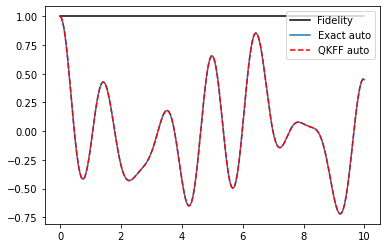

In [12]:
# O = np.kron(np.kron(np.kron(I,I),Z), np.kron(I,I))
# O = np.kron(Z,I)
# O = np.kron(Z, np.kron(I,I))

fidelity = [np.abs(np.conj(psi) @ phi)**2 for psi,phi in zip(exact_te, qkff_te)]


# exact_Z1 = [(np.conj(psi) @ O @ psi).real for psi in exact_te]
# qkff_Z1 = [(np.conj(psi) @ O @ psi).real for psi in qkff_te]

exact_auto = [(np.conj(init) @ psi).real for psi in exact_te]
qkff_auto = [(np.conj(init) @ psi).real for psi in qkff_te]


# plt.plot(ts, exact_Z1, label="Theoretical")
# plt.plot(ts, qkff_Z1, "r--", label="QKFF")
plt.plot(ts, fidelity, 'k', label="Fidelity")

plt.plot(ts, exact_auto, label="Exact auto")
plt.plot(ts, qkff_auto, "r--", label="QKFF auto")

# plt.plot(ts, qkff_Z1, 'r--', label="QKFF, R=1, M=6")
plt.legend(loc='upper right')

In [32]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

O = np.kron(np.kron(I, Z), np.kron(I, I))

exact_final_te = expm_multiply(-1j * H * ts[-1], init)
qkff_final_te = QKFFEvolve(ts[-1], c0)
ct = expm(-1j * ts[-1] * S_inv @ Hkl) @ c0

print(np.conj(qkff_final_te) @ O @ qkff_final_te)

obs = []
for psi in ref_states:
    obs.append(np.conj(psi) @ O @ psi)

print(sum([ct[i] * obs[i] for i in range(len(ct))]))

[ 0.89322456-0.10708714j -0.08044663-0.05849577j -0.13795643+0.02770995j
 -0.3247669 -0.00842242j -0.39411963-0.18559092j -0.33809253-0.37108348j
  0.29120446-0.38850003j  0.01408329+0.02631267j]
(0.5806229681903267+0j)
(-5.28004840380846e+75+2.5576123587056724e+75j)


In [10]:
def eff_overlap(basis_set): 
    eff_S = np.eye(len(basis_set), dtype=complex)
    for i in range(len(basis_set)): 
        for j in range(len(basis_set)): 
            eff_S[i][j] = np.abs(basis_set[i].conj().T @ basis_set[j])**2
    return eff_S

In [25]:
tau = 0.1
i = 8
M = 3
num_ref_states = 2

c = "01010101"
init = np.zeros(2**i)
init[int(''.join(c), 2)] = 1
added_indices = [int(''.join(c), 2)]
ham = heisenberg(i, x_hopping_coeff=1, y_hopping_coeff=2, z_hopping_coeff=3)

even, odd = trotter(i, x_hopping_coeff=1, y_hopping_coeff=2, z_hopping_coeff=3)
expm_est_trot = expm(-1j * tau * even) @ expm(-1j * tau * odd)
expm_ex_trot = expm(-1j * tau * ham)

basis_set = [init]
new_states = []
for j in range(1, M):
    new_states.append(np.linalg.matrix_power(expm_ex_trot, j) @ basis_set[-1])
basis_set.extend(new_states)


xs = np.eye(2**i)
sorted_probs_inds = np.argsort([np.abs(np.conj(x) @ basis_set[-1])**2 for x in xs])[::-1]
for k in range(len(sorted_probs_inds)):
    if not (sorted_probs_inds[k] in added_indices):
        num_ref_states += 1
        basis_set.append(xs[sorted_probs_inds[k]])

        new_states = []
        for j in range(1, M):
            new_states.append(np.linalg.matrix_power(expm_ex_trot, j) @ basis_set[-1])
        basis_set.extend(new_states)

        added_indices.append(sorted_probs_inds[k])
        break

print(np.round(eff_overlap(basis_set),3 ))

[[1.   +0.j 0.557+0.j 0.216+0.j 0.   +0.j 0.054+0.j 0.076+0.j]
 [0.557+0.j 1.   +0.j 0.557+0.j 0.054+0.j 0.   +0.j 0.054+0.j]
 [0.216+0.j 0.557+0.j 1.   +0.j 0.076+0.j 0.054+0.j 0.   +0.j]
 [0.   +0.j 0.054+0.j 0.076+0.j 1.   +0.j 0.593+0.j 0.206+0.j]
 [0.054+0.j 0.   +0.j 0.054+0.j 0.593+0.j 1.   +0.j 0.593+0.j]
 [0.076+0.j 0.054+0.j 0.   +0.j 0.206+0.j 0.593+0.j 1.   +0.j]]


In [26]:
tau = 0.1
i = 8
M = 3
num_ref_states = 2

c = "01010101"
init = np.zeros(2**i)
init[int(''.join(c), 2)] = 1
added_indices = [int(''.join(c), 2)]
ham = heisenberg(i, x_hopping_coeff=1, y_hopping_coeff=2, z_hopping_coeff=3)

even, odd = trotter(i, x_hopping_coeff=1, y_hopping_coeff=2, z_hopping_coeff=3)
expm_est_trot = expm(-1j * tau * even) @ expm(-1j * tau * odd)
expm_ex_trot = expm(-1j * tau * ham)

basis_set = [init]
new_states = []
for j in range(1, M):
    new_states.append(np.linalg.matrix_power(expm_est_trot, j) @ basis_set[-1])
basis_set.extend(new_states)


xs = np.eye(2**i)
sorted_probs_inds = np.argsort([np.abs(np.conj(x) @ basis_set[-1])**2 for x in xs])[::-1]
for k in range(len(sorted_probs_inds)):
    if not (sorted_probs_inds[k] in added_indices):
        num_ref_states += 1
        basis_set.append(xs[sorted_probs_inds[k]])

        new_states = []
        for j in range(1, M):
            new_states.append(np.linalg.matrix_power(expm_est_trot, j) @ basis_set[-1])
        basis_set.extend(new_states)

        added_indices.append(sorted_probs_inds[k])
        break

print(np.round(eff_overlap(basis_set),3 ))

[[1.   +0.j 0.527+0.j 0.174+0.j 0.   +0.j 0.05 +0.j 0.064+0.j]
 [0.527+0.j 1.   +0.j 0.527+0.j 0.055+0.j 0.   +0.j 0.05 +0.j]
 [0.174+0.j 0.527+0.j 1.   +0.j 0.073+0.j 0.055+0.j 0.   +0.j]
 [0.   +0.j 0.055+0.j 0.073+0.j 1.   +0.j 0.572+0.j 0.177+0.j]
 [0.05 +0.j 0.   +0.j 0.055+0.j 0.572+0.j 1.   +0.j 0.572+0.j]
 [0.064+0.j 0.05 +0.j 0.   +0.j 0.177+0.j 0.572+0.j 1.   +0.j]]
